# Online learning
We need to be able to continuously update our model and adapt to changes in the behavior of the attackers. To do so, we will be building an online learning model.

## Setup
Import the packages we need and read in the data:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )

Our functions for getting the X and y for our model:

In [2]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a pandas DataFrame and y is a pandas Series
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

We will work with the 2018 data to initially train our model, and then move to a monthly frequency to predict (and evaluate) each month and update the model afterwards (but before checking the next month).

In [3]:
X_2018, y_2018 = get_X_y(logs_2018, '2018', hackers_2018)

## Stochastic Gradient Descent Classification
Using SGD, we will be able to build a logistic regression model that can be updated:

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from ml_utils.partial_fit_pipeline import PartialFitPipeline

model = PartialFitPipeline([
    ('scale', StandardScaler()), 
    ('sgd', SGDClassifier(
        random_state=0, max_iter=1000, tol=1e-3, loss='log', 
        average=1000, learning_rate='adaptive', eta0=0.01
    ))
]).fit(X_2018, y_2018)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


As before, we can look at the coefficients for each of our features. The largest coefficient is `usernames_with_failures`:

In [5]:
[(col, coef) for col, coef in zip(X_2018.columns, model.named_steps['sgd'].coef_[0])]

[('usernames_with_failures', 1.5344651587934435),
 ('day_of_week_0', 0.06164314245322163),
 ('day_of_week_1', -0.026952199196979363),
 ('day_of_week_2', -0.05023016116182587),
 ('day_of_week_3', -0.025423230834628722),
 ('day_of_week_4', -0.03197652065173817),
 ('day_of_week_5', -0.005999014561309504),
 ('day_of_week_6', 0.07894278644002553),
 ('hour_0', 0.13431579778984487),
 ('hour_1', -0.043450924384377185),
 ('hour_2', -0.10167150407403336),
 ('hour_3', -0.07044270179704294),
 ('hour_4', 0.08923744038825357),
 ('hour_5', -0.006100526924355815),
 ('hour_6', 0.029732804125848195),
 ('hour_7', 0.024513201292794953),
 ('hour_8', -0.007796800912537199),
 ('hour_9', -0.08403088314621063),
 ('hour_10', 0.11196686595127289),
 ('hour_11', -0.046980848221753004),
 ('hour_12', -0.025433925615173165),
 ('hour_13', -0.013031174530186176),
 ('hour_14', 0.0001413771763088802),
 ('hour_15', 0.012193749068599156),
 ('hour_16', -0.014008591558021767),
 ('hour_17', -0.04443177803318395),
 ('hour_18',

### Predict, Evaluate, and Update Model

#### Step 1: Gather test data
We will use January 2019:

In [6]:
with sqlite3.connect('logs/logs.db') as conn:
    logs_2019 = pd.read_sql(
        """
        SELECT * 
        FROM logs 
        WHERE datetime BETWEEN "2019-01-01" AND "2020-01-01";
        """, conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2019 = pd.read_sql(
        """
        SELECT * 
        FROM attacks 
        WHERE start BETWEEN "2019-01-01" AND "2020-01-01";
        """, conn, parse_dates=['start', 'end']
    ).assign(
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )

X_jan, y_jan = get_X_y(logs_2019, '2019-01', hackers_2019)

#### Step 2: Evaluate Performance
Recall is too low here:

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_jan, model.predict(X_jan)))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     42549
        True       1.00      0.70      0.82        30

   micro avg       1.00      1.00      1.00     42579
   macro avg       1.00      0.85      0.91     42579
weighted avg       1.00      1.00      1.00     42579



c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


We can visualize where we are on the ROC and precision-recall curves. Let's make a convenience function since we will be plotting these often:

In [8]:
from ml_utils.classification import confusion_matrix_visual, plot_pr_curve, plot_roc

def plot_performance(model, X, y, threshold=None, title=None, show_target=True):
    """
    Plot the ROC, confusion matrix, and precision-recall curve side-by-side.
    
    Parameters:
        - model: The model object to use for prediction.
        - X: The features to pass in for prediction from the testing set.
        - y: The actuals to evaluate the prediction.
        - threshold: Value to use as threshold when predicting probabilities.
        - title: A title for the subplots.
        - show_target: Whether to show the target regions on the ROC/PR curve.
        
    Returns:
        Matplotlib Axes.    
    """
    # make the subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # plot each visualization
    plot_roc(y, model.predict_proba(X)[:,1], ax=axes[0])
    confusion_matrix_visual(
        y, model.predict_proba(X)[:,1] >= (threshold or 0.5), 
        class_labels=[False, True], ax=axes[1]
    )
    plot_pr_curve(y, model.predict_proba(X)[:,1], ax=axes[2])

    # show the target regions if desired
    if show_target:
        axes[0].axvspan(0, 0.05, color='palegreen', alpha=0.5)
        axes[0].axhspan(0.75, 1, color='paleturquoise', alpha=0.5)
        axes[0].annotate(
            'region with acceptable FPR and TPR', 
            xy=(0.05, 0.75), xytext=(0.07, 0.69), 
            arrowprops=dict(arrowstyle='->')
        )

        axes[2].axvspan(0.75, 1, color='palegreen', alpha=0.5)
        axes[2].axhspan(0.95, 1, color='paleturquoise', alpha=0.5)
        axes[2].annotate(
            'region with acceptable\nprecision and recall', 
            xy=(0.75, 0.95), xytext=(0.3, 0.6), 
            arrowprops=dict(arrowstyle='->')
        )

    # show the title if specified
    if title:
        plt.suptitle(title)

    return axes

Notice we are not quite where we need to be:

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.3, 0.8, 'current performance\n- precision = 100%\n- recall = 70%')

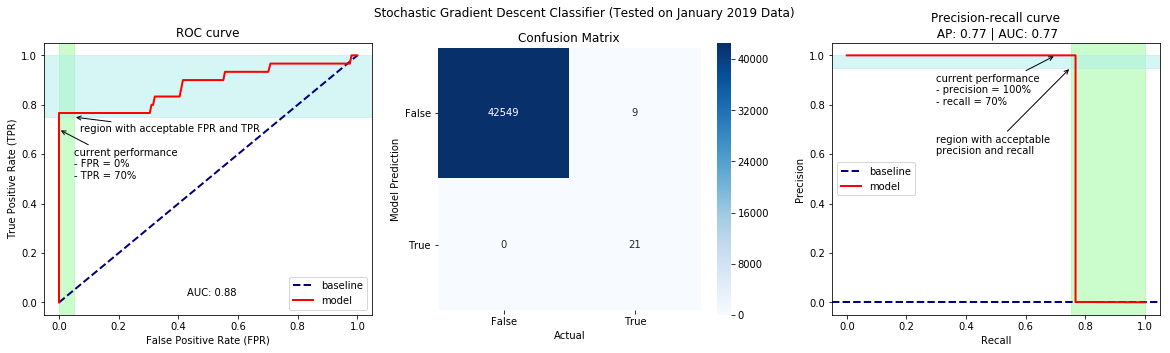

In [9]:
axes = plot_performance(
    model, X_jan, y_jan, 
    title='Stochastic Gradient Descent Classifier '\
        '(Tested on January 2019 Data)'
)
axes[0].annotate(
    'current performance\n- FPR = 0%\n- TPR = 70%', 
    xy=(0, .7), xytext=(0.05, 0.5), 
    arrowprops=dict(arrowstyle='->')
)

axes[2].annotate(
    'current performance\n- precision = 100%\n- recall = 70%', 
    xy=(.7, 1), xytext=(0.3, 0.8), 
    arrowprops=dict(arrowstyle='->')
)

##### Try picking a custom threshold based on acceptable TPR and FPR
We will be using the threshold with the precision-recall curve, but here is how to get it from the ROC curve:

In [10]:
from ml_utils.classification import find_threshold_roc

threshold = find_threshold_roc(
    y_jan, model.predict_proba(X_jan)[:,1], 
    fpr_below=0.05, tpr_above=0.75
).max()
threshold

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.011191747078992526

##### Try picking a custom threshold based on acceptable recall and precision
Note this is actually the same threshold:

In [11]:
from ml_utils.classification import find_threshold_pr

threshold = find_threshold_pr(
    y_jan, model.predict_proba(X_jan)[:,1], 
    min_precision=0.95, min_recall=0.75
).max()
threshold

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.011191747078992526

Let's find the metrics at this threshold so we can plot where we are on the ROC and precision-recall curves:

In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve

fpr, tpr, thresholds = roc_curve(y_jan, model.predict_proba(X_jan)[:,1])
mask = thresholds == threshold
fpr_at_threshold, tpr_at_threshold = fpr[mask], tpr[mask]

precision, recall, thresholds = precision_recall_curve(y_jan, model.predict_proba(X_jan)[:,1])
mask = thresholds == threshold
# precision and recall have one extra value added at the end for plotting, so we have to remove to use the mask
p_at_threshold, r_at_threshold = precision[:-1][mask], recall[:-1][mask]

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Using this threshold, we are able to move into the acceptable region:

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.1, 0.75, 'chosen threshold = 1.12%\n- precision=100.00%\n- recall=76.67%')

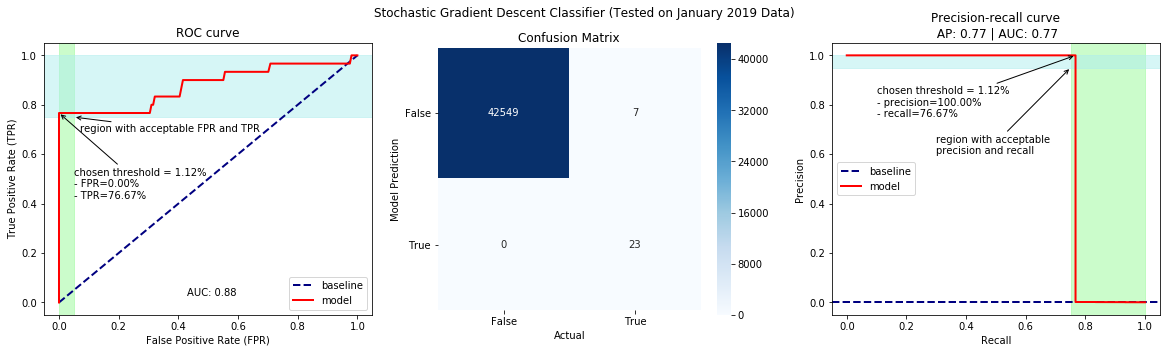

In [13]:
axes = plot_performance(
    model, X_jan, y_jan, threshold=threshold, 
    title='Stochastic Gradient Descent Classifier '\
        '(Tested on January 2019 Data)'
)

axes[0].annotate(
    f'chosen threshold = {threshold:.2%}\n'
    f'- FPR={fpr_at_threshold[0]:.2%}\n- TPR={tpr_at_threshold[0]:.2%}', 
    xy=(fpr_at_threshold, tpr_at_threshold), xytext=(0.05, 0.42), 
    arrowprops=dict(arrowstyle='->')
)

axes[2].annotate(
    f'chosen threshold = {threshold:.2%}\n'
    f'- precision={p_at_threshold[0]:.2%}\n- recall={r_at_threshold[0]:.2%}', 
    xy=(r_at_threshold, p_at_threshold), xytext=(0.1, 0.75), 
    arrowprops=dict(arrowstyle='->')
)

#### Step 4: Update the model to include true labels for previously predicted test data (Jan 2019)

In [14]:
# update
model.partial_fit(X_jan, y_jan)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PartialFitPipeline(memory=None,
          steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=1000, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

#### Step 5: Repeat process (this time we use Feb 2019)

In [15]:
X_feb, y_feb = get_X_y(logs_2019, '2019-02', hackers_2019)

print(classification_report(y_feb, model.predict_proba(X_feb)[:,1] >= threshold))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     39373
        True       1.00      0.79      0.88        28

   micro avg       1.00      1.00      1.00     39401
   macro avg       1.00      0.89      0.94     39401
weighted avg       1.00      1.00      1.00     39401



c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Notice the model is better and now a larger section of both the ROC curve and the precision-recall curve fall in the acceptable performance region:

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12D31430>,
      dtype=object)

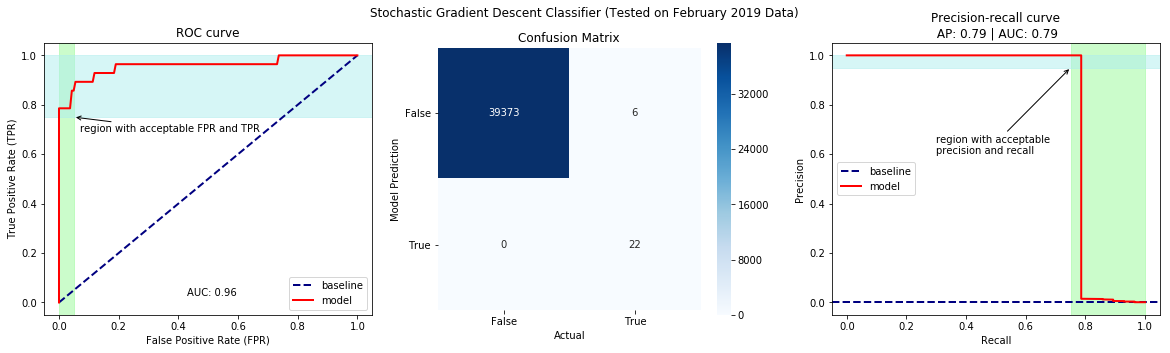

In [16]:
plot_performance(
    model, X_feb, y_feb, threshold=threshold,
    title='Stochastic Gradient Descent Classifier '\
        '(Tested on February 2019 Data)'
)

## Putting our model to the test
In the time that we've been building all these models, March 2019 has come and gone. Our stakeholders are done waiting around for us and want results. Let's show our performance.

### Step 1: Update with the February 2019 data first

In [17]:
model.partial_fit(X_feb, y_feb)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PartialFitPipeline(memory=None,
          steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=1000, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

### Step 2: Predict the March data for the stakeholders and send it off

In [18]:
X_march, y_march = get_X_y(logs_2019, '2019-03', hackers_2019)
march_2019_preds = model.predict_proba(X_march)[:,1] >= threshold

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Step 3: Evaluation
The subject area experts examined our predictions and returned the following after checking our predictions. We are meeting our metrics:

In [19]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_march, march_2019_preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     41494
        True       1.00      0.77      0.87        30

   micro avg       1.00      1.00      1.00     41524
   macro avg       1.00      0.88      0.93     41524
weighted avg       1.00      1.00      1.00     41524



We were able to adapt to new data and still meet our performance requirements:

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0.2, 0.75, 'current performance\n- precision=100%\n- recall=77%')

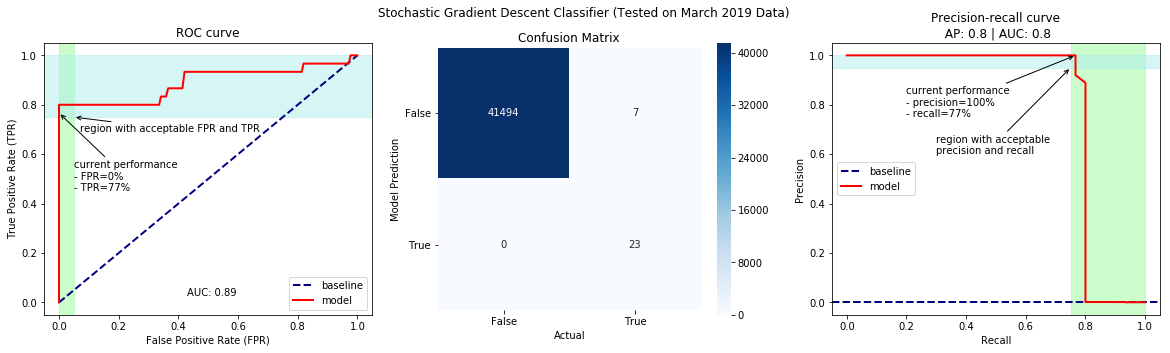

In [20]:
axes = plot_performance(
    model, X_march, y_march, threshold=threshold,
    title='Stochastic Gradient Descent Classifier '\
        '(Tested on March 2019 Data)'
)

axes[0].annotate(
    'current performance\n- FPR=0%\n- TPR=77%', 
    xy=(0, 23/30), xytext=(0.05, 0.45), 
    arrowprops=dict(arrowstyle='->')
)
axes[2].annotate(
    'current performance\n- precision=100%\n- recall=77%', 
    xy=(23/30, 1), xytext=(0.2, 0.75), 
    arrowprops=dict(arrowstyle='->')
)